Data Loading and Initial Inspection

In [1]:
import pandas as pd
import numpy as np

# Load the datasets
direct_hydrogenation = pd.read_csv('direct_hydrogenation.csv')

# Display the first few rows of each dataset
direct_hydrogenation.head()
direct_hydrogenation['hydrogenation_type'] = 'direct'

Data Preprocessing

Handle Missing Values

In [2]:
# Check for missing values
print(direct_hydrogenation.isnull().sum())

# Fill or drop missing values
combined_data = direct_hydrogenation.dropna()

Catalysts             0
conversion            0
yield                 0
selectivity           0
furfural amt          0
catalyst amt          0
solvent               0
solvent amt           0
time                  0
temperature           0
pressure              0
hydrogenation_type    0
dtype: int64


Exploratory Data Analysis (EDA)

Correlation Matrix and Heatmap

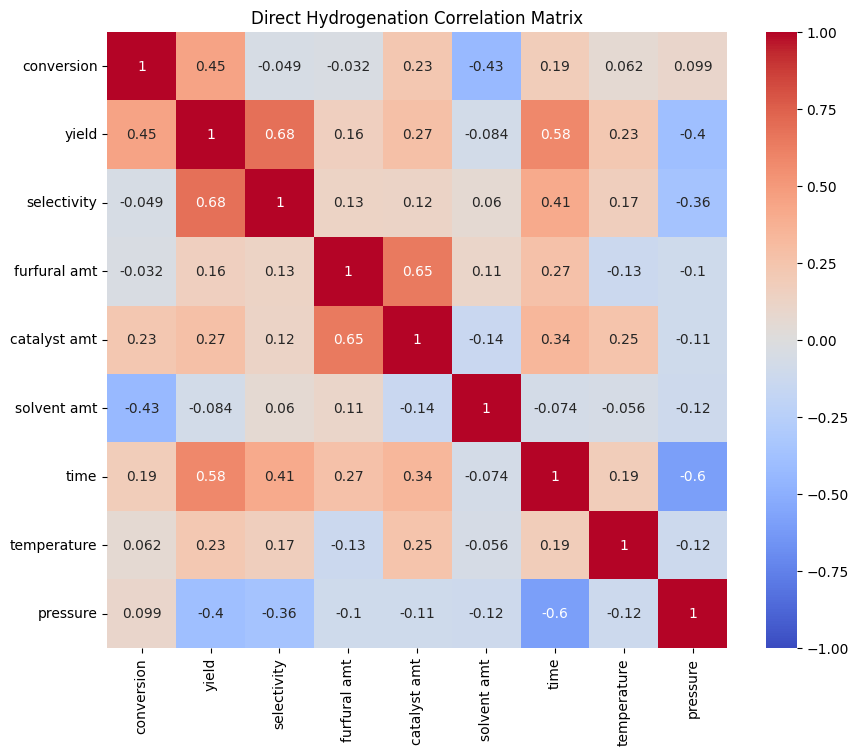

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the numeric columns for the correlation matrix
numeric_columns = direct_hydrogenation.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix
correlation_matrix = direct_hydrogenation[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Direct Hydrogenation Correlation Matrix')
plt.show()

Distribution Plots

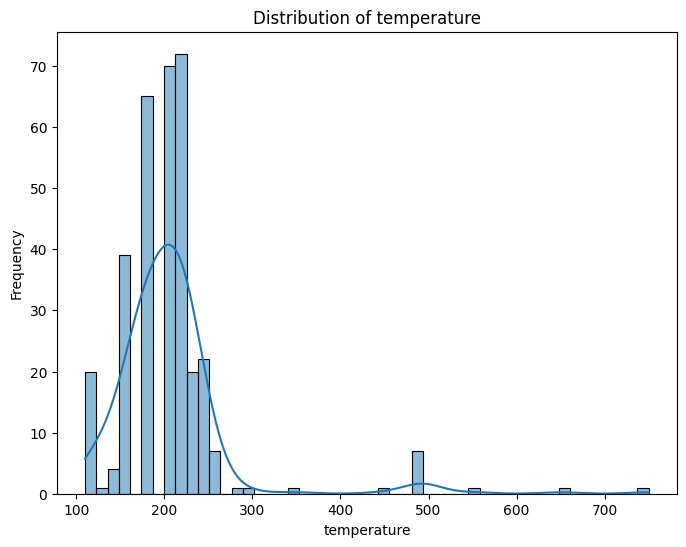

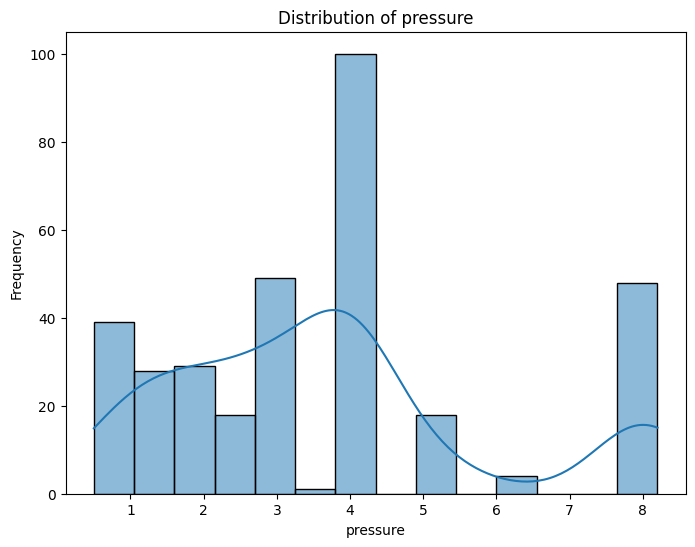

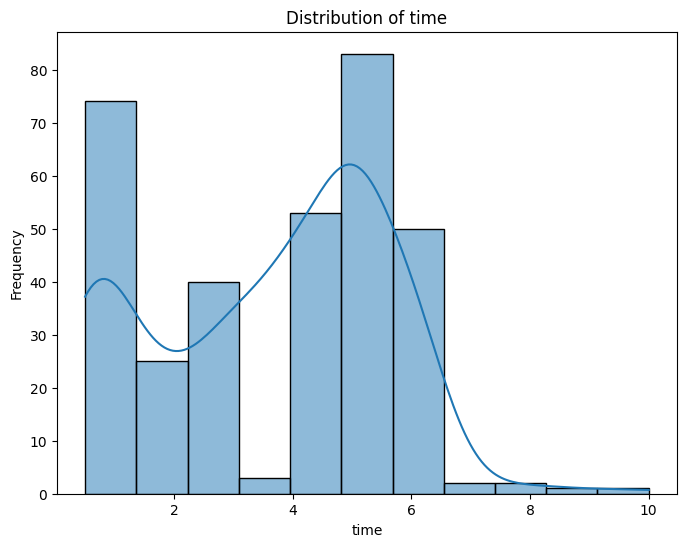

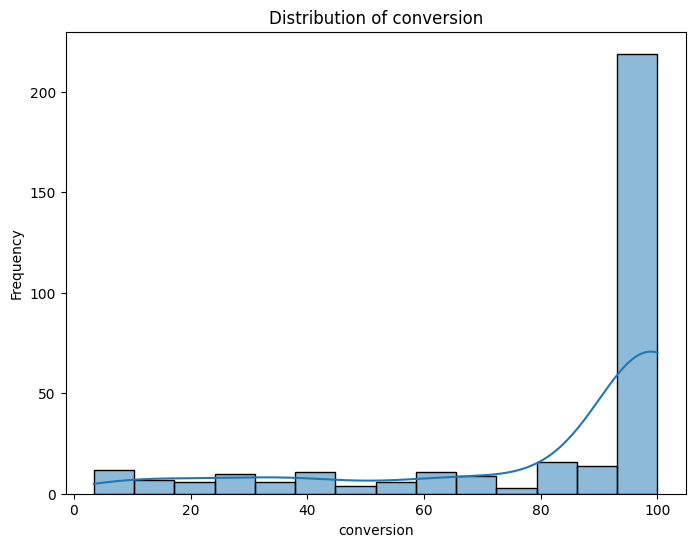

In [4]:
# Distribution plots for key variables
key_variables = ['temperature', 'pressure', 'time', 'conversion']
for var in key_variables:
    try:
        plt.figure(figsize=(8, 6))
        sns.histplot(combined_data[var], kde=True)
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.show()
    except KeyError:
        print(f"Error: Column '{var}' not found in the DataFrame.")


Boxplot

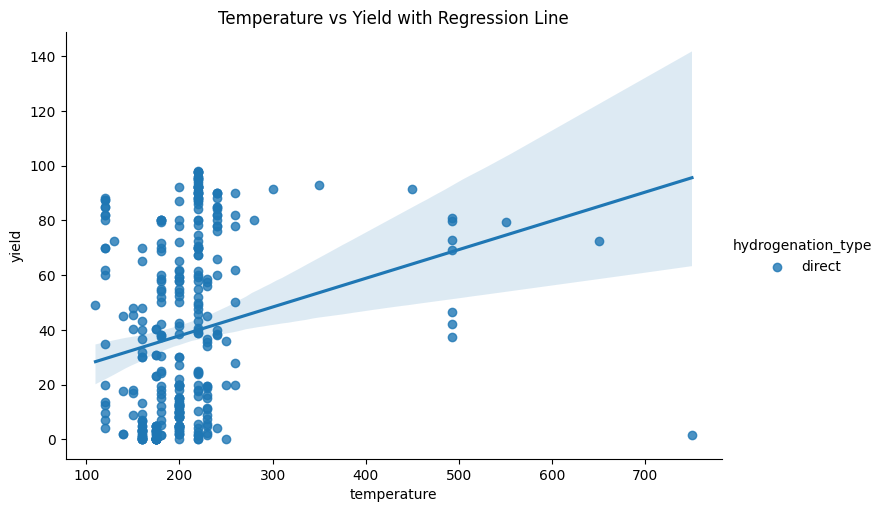

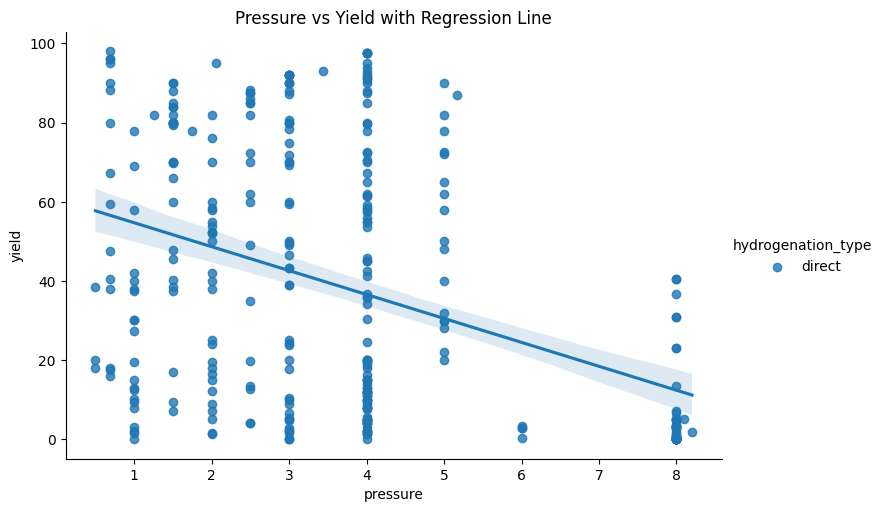

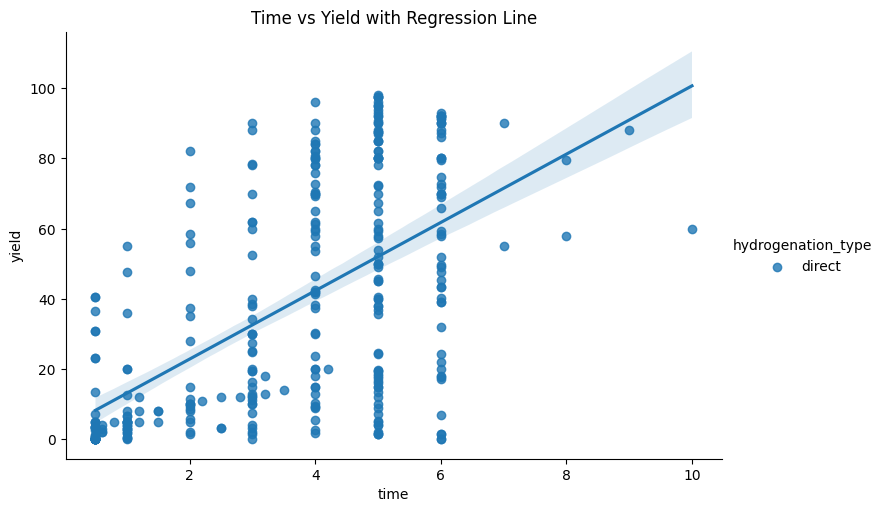

In [5]:
# Scatter plots with regression lines
sns.lmplot(x='temperature', y='yield', hue='hydrogenation_type', data=combined_data, aspect=1.5)
plt.title('Temperature vs Yield with Regression Line')
plt.show()

sns.lmplot(x='pressure', y='yield', hue='hydrogenation_type', data=combined_data, aspect=1.5)
plt.title('Pressure vs Yield with Regression Line')
plt.show()

sns.lmplot(x='time', y='yield', hue='hydrogenation_type', data=combined_data, aspect=1.5)
plt.title('Time vs Yield with Regression Line')
plt.show()

Feature, Model Training and Evaluation

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Define target variable and features (adjust based on your data)
target_variable = ['conversion', 'yield', 'selectivity']
features = combined_data.drop(target_variable, axis=1).columns

# Identify numerical and categorical features (adjust based on your data)
numeric_features = ['temperature', 'pressure', 'time','solvent amt', 'catalyst amt', 'furfural amt']
categorical_features = ['Catalysts', 'hydrogenation_type']

# Preprocessing pipeline with handle_unknown='ignore'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define Model 1 (Random Forest Regressor)
model_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

X = combined_data[features]  # Select features from DataFrame
y = combined_data[target_variable]  # Select target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model 1
model_1.fit(X_train, y_train)

# Evaluate Model 1
y_pred = model_1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)/10
print(f'Model: Random Forest Regressor - Mean Squared Error: {mse}')

# Cross-validation for Model 1
cv_scores = cross_val_score(model_1, X, y, cv=5, scoring='neg_mean_squared_error')/10
print(f'Cross-validated MSE (Model 1): {-cv_scores.mean()}')



Model: Random Forest Regressor - Mean Squared Error: 82.85956915047811
Cross-validated MSE (Model 1): 96.16354595382764


Model Interpretation

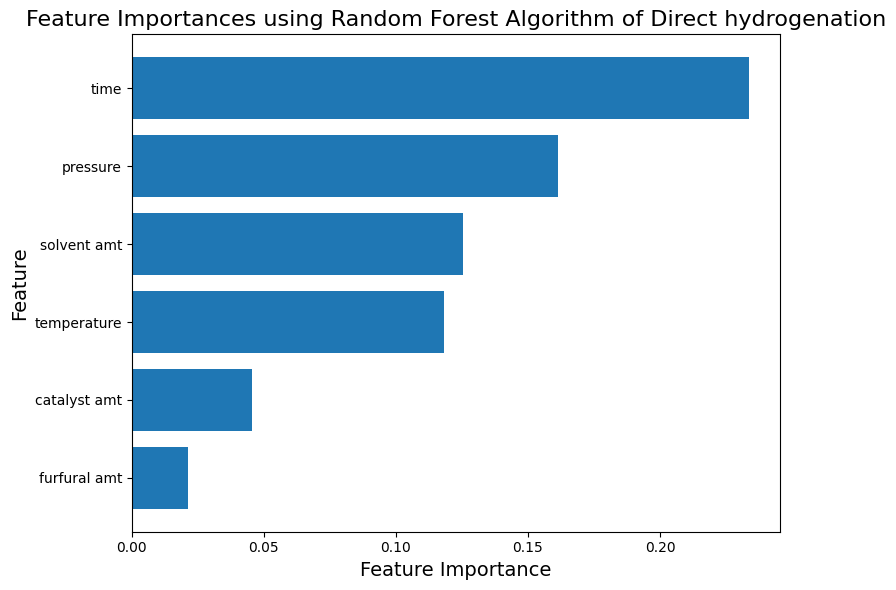

In [7]:
selected_features = ['temperature', 'pressure', 'time', 'solvent amt', 'catalyst amt', 'furfural amt']

# 1. Feature Importances
importances = model_1.named_steps['regressor'].feature_importances_  # Access importances from Random Forest
feature_names = numeric_features + list(model_1.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
feature_importances = pd.Series(importances, index=feature_names)

# 2. Filter by Selected Features
filtered_importances = feature_importances[selected_features]  # Filter based on selected features

# 3. Sort Filtered Importances
sorted_filtered_importances = filtered_importances.sort_values(ascending=False)

# 4. Plot Selected Features
plt.figure(figsize=(8, 6))  # Adjust figure size as desired
plt.barh(sorted_filtered_importances.index, sorted_filtered_importances.values)  # Use index and values for plotting
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("Feature Importances using Random Forest Algorithm of Direct hydrogenation", fontsize=16)  # Adjusted title
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature on top
plt.tight_layout()
plt.show()
